<a href="https://colab.research.google.com/github/ghimiresushma99/dump/blob/main/Extract_Missing_Roads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon, box
from shapely.ops import transform
import pyproj
from functools import partial
from shapely.geometry import LineString

# External Dataset
# - load geojson
# - split lines at vertices
# Internal Dataset
# - Load geojson
# - Draw 10m buffer of the roads
# - Erase buffer area from bbox
# Operation
# - Select all the external dataset roads in erased buffer area (select by location with spatial operation intersect such that all linestring is returned if it intersects polygon)

external_dataset_filepath = "/content/janakpur_external_road.geojson"
internal_dataset_filepath = "/content/janakpur_baato_road.geojson"

# --- External Dataset ---
# Load external GeoJSON
try:
  external_gdf = gpd.read_file(external_dataset_filepath)
except FileNotFoundError:
  print(f"Error: {external_dataset_filepath} not found. Please upload the valid file.")
print(external_gdf.shape)

external_gdf = external_gdf.to_crs("EPSG:32645") # Project to UTM

# Split lines at vertices (if needed)
# external_gdf = external_gdf.explode(ignore_index=True)
print(external_gdf.shape)

(2269, 10)
(2269, 10)


In [ ]:
def split_road_at_vertices(road):
    segments = []
    # Check if the geometry is a MultiLineString
    if road.geom_type == 'MultiLineString':
        # If it is, iterate through each LineString within it
        # Use .geoms to access individual LineStrings
        for line in road.geoms:
            coords = list(line.coords)  # Extract coordinates of the LineString
            for i in range(len(coords) - 1):  # Loop through consecutive pairs of points
                segment = LineString([coords[i], coords[i + 1]])
                segments.append(segment)
    else:
        # If it's a LineString, proceed as before
        coords = list(road.coords)  # Extract coordinates of the LineString
        for i in range(len(coords) - 1):  # Loop through consecutive pairs of points
            segment = LineString([coords[i], coords[i + 1]])
            segments.append(segment)
    return segments

# Process each road and create a new GeoDataFrame
all_segments = []

# Process each road
for index, road in external_gdf.iterrows(): # Modified line: unpack the tuple
    segments = split_road_at_vertices(road.geometry) # Access the geometry of the road with road.geometry
    all_segments.extend(segments)  # Add segments to the list

# Create a new GeoDataFrame
external_gdf_new = gpd.GeoDataFrame(geometry=all_segments, crs=external_gdf.crs)
print(external_gdf_new.shape)
external_gdf_new.head()

(26731, 1)


,geometry
0,"LINESTRING (393168.411 2957129.668, 393171.078..."
1,"LINESTRING (393171.078 2957126.234, 393173.722..."
2,"LINESTRING (393173.722 2957090.62, 393173.78 2..."
3,"LINESTRING (393173.78 2957086.931, 393178.328 ..."
4,"LINESTRING (393178.328 2957084.898, 393215.748..."


In [ ]:
import geopandas as gpd
from shapely.geometry import LineString

def split_road_at_vertices(road, attributes):
    """
    Splits a road (LineString or MultiLineString) into individual segments (LineString)
    while retaining the attributes of the original road.
    """
    segments = []
    # Check if the geometry is a MultiLineString
    if road.geom_type == 'MultiLineString':
        # Iterate through each LineString within the MultiLineString
        for line in road.geoms:
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                # Create a new segment and associate the attributes
                segment = {'geometry': LineString([coords[i], coords[i + 1]]), **attributes}
                segments.append(segment)
    elif road.geom_type == 'LineString':
        # Handle single LineString case
        coords = list(road.coords)
        for i in range(len(coords) - 1):
            segment = {'geometry': LineString([coords[i], coords[i + 1]]), **attributes}
            segments.append(segment)
    return segments

# Process each road and create a new GeoDataFrame
all_segments = []

# Iterate through each road in the GeoDataFrame
for index, row in external_gdf.iterrows():
    # Convert row to dictionary to retain attributes
    attributes = dict(row)
    # Remove 'geometry' key from attributes to avoid conflict
    attributes.pop('geometry', None)
    # Split the road into segments
    segments = split_road_at_vertices(row.geometry, attributes)
    all_segments.extend(segments)

# Create a new GeoDataFrame from the list of segments
external_gdf_new = gpd.GeoDataFrame(all_segments, crs=external_gdf.crs)

# Print the number of features and a preview of the resulting GeoDataFrame
print(external_gdf_new.shape)
external_gdf_new.head()

(26731, 10)


,geometry,road_name_,road_nam_1,road_type,road_categ,road_class,road_id,road_lane,road_width,networkGrp
0,"LINESTRING (393168.411 2957129.668, 393171.078...",Janaki Road,None,black_topped,minor,other_urban_road,5501081.0,double_lane,6.0,0.0
1,"LINESTRING (393171.078 2957126.234, 393173.722...",Janaki Road,None,black_topped,minor,other_urban_road,5501081.0,double_lane,6.0,0.0
2,"LINESTRING (393173.722 2957090.62, 393173.78 2...",Janaki Road,None,black_topped,minor,other_urban_road,5501081.0,double_lane,6.0,0.0
3,"LINESTRING (393173.78 2957086.931, 393178.328 ...",Janaki Road,None,black_topped,minor,other_urban_road,5501081.0,double_lane,6.0,0.0
4,"LINESTRING (393178.328 2957084.898, 393215.748...",Janaki Road,None,black_topped,minor,other_urban_road,5501081.0,double_lane,6.0,0.0


(2558, 45)


<ipython-input-58-84a1e8362354>:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  erased_bbox = bbox.difference(internal_gdf.unary_union)


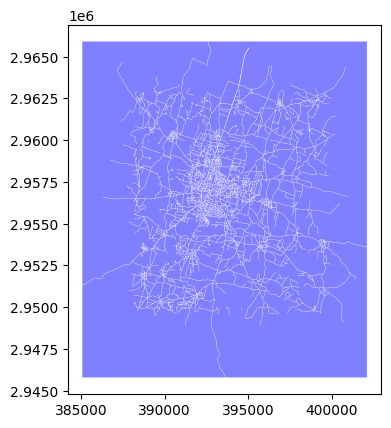

In [ ]:
# --- Internal Dataset ---
try:
    internal_gdf = gpd.read_file(internal_dataset_filepath)
except FileNotFoundError:
    print(f"Error: {internal_dataset_filepath} not found. Please upload the valid file.")
print(internal_gdf.shape)

# Project to a suitable UTM zone if needed for accurate buffering
# Example: Projecting to UTM zone 45N  (Adjust EPSG code if necessary)
internal_gdf = internal_gdf.to_crs("EPSG:32645") # Project to UTM

# Create a buffer of 10 meters around the roads
internal_gdf['buffer'] = internal_gdf.buffer(10)
internal_gdf = internal_gdf.set_geometry('buffer')

# Calculate a bounding box around the buffered roads
total_bounds = internal_gdf.total_bounds
bbox = box(total_bounds[0], total_bounds[1], total_bounds[2], total_bounds[3])

# Erase the buffer area from the bbox
erased_bbox = bbox.difference(internal_gdf.unary_union)

# Convert the erased_bbox to a GeoDataFrame
erased_bbox_gdf = gpd.GeoDataFrame([1], geometry=[erased_bbox], crs="EPSG:32645")

import matplotlib.pyplot as plt
erased_bbox_gdf.plot(color='blue', alpha=0.5, label='Erased BBox')
plt.show()

In [ ]:
# --- Operation ---
# Perform spatial intersection between external roads and the erased buffer
# using 'intersects' operation
missing_roads = gpd.sjoin(external_gdf_new, erased_bbox_gdf, how="inner", predicate="intersects")

print(external_gdf.shape)
print(missing_roads.shape)
missing_roads.head()

(2269, 10)
(8429, 12)


,geometry,road_name_,road_nam_1,road_type,road_categ,road_class,road_id,road_lane,road_width,networkGrp,index_right,0
27,"LINESTRING (393381.682 2956909.377, 393389.414...",Janaki Road,None,black_topped,minor,other_urban_road,5501081.0,double_lane,6.0,0.0,0,1
28,"LINESTRING (393389.414 2956895.904, 393394.303...",Janaki Road,None,black_topped,minor,other_urban_road,5501081.0,double_lane,6.0,0.0,0,1
29,"LINESTRING (393320.084 2952513.798, 393326.102...",None,None,None,subsidiary,None,585.0,None,0.0,0.0,0,1
30,"LINESTRING (393326.102 2952508.517, 393330.148...",None,None,None,subsidiary,None,585.0,None,0.0,0.0,0,1
31,"LINESTRING (393330.148 2952505.412, 393330.32 ...",None,None,None,subsidiary,None,585.0,None,0.0,0.0,0,1


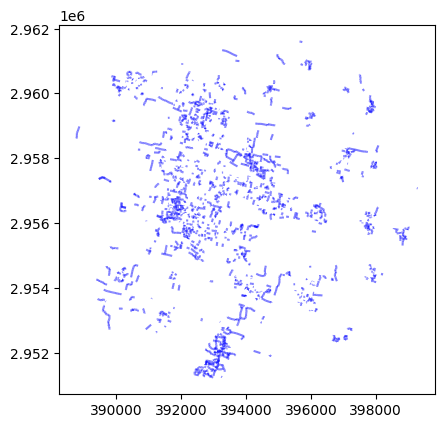

In [ ]:
missing_roads.plot(color='blue', alpha=0.5, label='Erased BBox')
plt.show()

In [ ]:
# Convert all columns except 'geometry' to string type
for column in missing_roads.columns:
    if column != 'geometry':
        # Check if the column is numeric and needs conversion
        if isinstance(column, int):
            # Rename numeric column names to strings (optional)
            missing_roads = missing_roads.rename(columns={column: str(column)})

        # Apply string conversion to the entire column, handling potential errors
        missing_roads[column] = missing_roads[column].apply(lambda x: str(x) if not isinstance(x, (float, int)) else str(int(x)))


output_filepath = "/content/intersected_roads.geojson"  # Define output filepath
missing_roads.to_file(output_filepath, driver="GeoJSON")
print(f"Intersected roads exported to: {output_filepath}")

In [ ]:
# - External Dataset
# - load geojson and project to 45N crs
# - split lines at vertices


# Internal Dataset
# - Load geojson and project to 45N crs
# - Draw 10m buffer of the roads
# - Erase buffer area from bbox

# Operation
# - Select all the external dataset roads in erased buffer area (select by location with spatial operation intersect such that all linestring is returned if it intersects polygon)
# - Return ouput projected back to WGS84
